In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
sns.set_style('whitegrid')

In [3]:
import category_encoders as ce

In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, DBSCAN

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import tensorflow as tf

In [7]:
import keras
from keras.models import Model
import kerastuner

In [8]:
from sklearn import metrics

In [9]:
from keras.layers import Dense, Input, Dropout

## Keras notebook with clustering added
1. Plot PCA explained variance, pick a number of PCA dimensions to pass to NN.
1. Visualize 2D PCA of this dataset.
1. Conduct elbow and/or silhouette tests of the data reduced to various PCA dimensions.
1. Select an optimal clustering algorithm and hyperparameters and number of PCA dimensions to cluster on, then cluster.
1. Make cluster id a categorical feature, hot encode it.
1. Pass PCA dimensions and cluster id to three layer NN.
1. Tune the network & train up the best candidate.

In [10]:
tf_df = pd.read_csv('../train_features.csv',index_col='sig_id')
tts_df = pd.read_csv('../train_targets_scored.csv',index_col='sig_id')
tf_df['cp_type']=tf_df['cp_type'].astype('category')
scaler = MinMaxScaler(feature_range=(-0.5,0.5))
tf_df['cp_time']=scaler.fit_transform((np.array(tf_df['cp_time'])).reshape(-1,1))
tf_df['cp_dose']=tf_df['cp_dose'].astype('category')
transformer = StandardScaler()
tf_df.loc[:,'g-0':'c-99']=transformer.fit_transform(tf_df.loc[:,'g-0':'c-99'])

In [11]:
print(tf_df['cp_type'].unique(),tf_df['cp_dose'].unique())

['trt_cp', 'ctl_vehicle']
Categories (2, object): ['trt_cp', 'ctl_vehicle'] ['D1', 'D2']
Categories (2, object): ['D1', 'D2']


In [12]:
oenc = ce.ordinal.OrdinalEncoder()
tf_df = oenc.fit_transform(tf_df)
tf_df.sample(5)

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_ec319843a,1,-0.5,2,-0.654289,-0.407235,0.920863,0.250243,0.927896,0.263138,1.064330,...,0.031165,0.406041,0.532733,0.256823,-0.183885,0.872009,0.099231,0.553976,0.107125,-0.299736
id_535884392,1,-0.5,2,-0.471710,0.508384,-0.176066,0.501508,-0.070971,0.776975,0.491105,...,0.738957,0.426311,-0.009464,-0.366794,-0.340770,-0.036443,0.372041,-0.422498,0.274719,-0.085230
id_2988f18e7,1,-0.5,2,-0.111935,1.434959,-0.889297,-1.171559,0.762597,-0.244848,0.582676,...,0.147189,-0.206464,-0.142103,0.411114,0.080060,-0.272072,0.313876,0.747568,0.482318,-0.117903
id_c0fecd46e,1,0.5,1,-0.452691,0.233994,-0.290577,0.834984,-0.665214,0.186741,0.846056,...,0.710114,0.801696,0.306722,0.706122,0.380494,0.778837,0.535415,-0.073703,0.788075,0.867615
id_5994f5ca2,1,0.0,2,-0.306930,0.250735,0.011824,0.570245,0.472888,0.464264,-0.036448,...,0.162586,0.112273,0.593882,0.308934,-0.008801,0.352201,0.036212,-0.076403,0.591813,-0.187369


In [13]:
tf_df['cp_type']=tf_df['cp_type']-1
tf_df['cp_dose']=tf_df['cp_dose']-1
tf_df.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,0,-0.5,0,0.583933,0.804317,-0.386357,-0.739765,-0.243924,-0.740369,-1.198991,...,0.377638,0.352428,0.659876,0.499484,0.146278,0.621219,0.031745,0.347587,0.463460,0.510769
id_000779bfc,0,0.5,0,-0.124925,0.620898,0.141784,-0.022707,0.931772,0.559230,0.224552,...,0.021367,0.595227,0.491617,0.248281,0.371742,0.517798,0.298922,0.294874,0.587507,0.737704
id_000a6266a,0,0.0,0,0.272457,0.833861,1.353417,-0.166708,-0.086861,1.168288,0.153607,...,-0.127850,-0.082397,0.561309,0.247948,-0.378278,0.022296,-0.086525,0.093651,-0.511093,0.706452
id_0015fd391,0,0.0,0,-0.546995,-0.188856,-0.403446,0.470350,3.880216,-0.568667,-2.260896,...,-0.814697,-0.089447,-2.556236,-0.416627,-0.164899,-0.573436,-0.561987,-0.293593,0.045047,-0.365011
id_001626bd3,0,0.5,1,-0.411783,-0.375722,0.789552,0.642035,1.318373,-0.581300,-0.358079,...,0.236669,0.228262,0.589635,0.744707,0.490563,0.031073,0.278143,0.391377,0.049952,0.720231


1. Plot PCA explained variance.

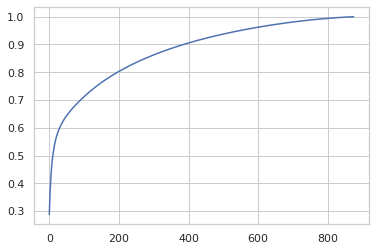

In [14]:
pca = PCA()
pca_df = pd.DataFrame(pca.fit_transform(tf_df),index=tf_df.index)
var_explain = np.cumsum(pca.explained_variance_ratio_)
plt.plot(var_explain)
plt.show()

1. Pick a number of PCA dimension to pass as NN inputs:

In [15]:
var_explain[var_explain<0.6]

array([0.28775034, 0.32782045, 0.36001795, 0.38915401, 0.41040127,
       0.43118162, 0.44850562, 0.46499128, 0.47759148, 0.48873435,
       0.4990097 , 0.50816347, 0.51619619, 0.52375074, 0.53113156,
       0.5382704 , 0.54462608, 0.55056391, 0.55589954, 0.56097575,
       0.56532816, 0.56965964, 0.5737198 , 0.5775231 , 0.58112902,
       0.58458155, 0.58797941, 0.59125316, 0.59438609, 0.59741847])

Thirty is a surprisingly tractable number.

In [16]:
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,865,866,867,868,869,870,871,872,873,874
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,-7.107259,-1.168778,-0.310614,7.708409,-4.206789,-2.876220,2.219229,3.733861,-2.235870,-1.567758,...,-0.084736,-0.026212,0.031605,-0.263764,-0.086280,-0.098859,-0.105082,0.025546,-0.127693,0.157130
id_000779bfc,-6.361546,3.714502,7.178185,-4.380409,3.715265,3.302999,1.701060,0.001956,0.150894,1.241798,...,0.173947,-0.148990,0.103297,-0.281370,-0.210922,0.142719,-0.128665,0.015662,-0.100796,-0.173679
id_000a6266a,-1.731815,2.388899,-3.213443,-5.197731,0.391750,-1.006098,1.554354,-2.843535,0.268474,-3.741226,...,-0.167156,0.017084,0.165514,-0.069780,-0.144941,0.343237,-0.026656,0.052571,-0.037894,0.029508
id_0015fd391,9.183812,-2.753994,-5.093871,-8.610308,-4.969259,-6.347330,1.799940,-6.918809,-0.713619,4.037423,...,0.119759,-0.337072,0.247771,-0.249129,-0.185941,-0.461194,-0.197853,0.209215,0.192482,0.067413
id_001626bd3,-6.472174,1.019788,4.140000,-8.496081,-3.039038,-2.312408,-0.923099,0.415253,6.733137,4.569647,...,-0.301818,-0.322237,0.228351,0.021456,-0.265926,0.164691,-0.063793,0.038360,0.059974,0.017034


In [17]:
pca_df.columns

RangeIndex(start=0, stop=875, step=1)

2. Visualize 2D PCA of this dataset.

<AxesSubplot:xlabel='0', ylabel='1'>

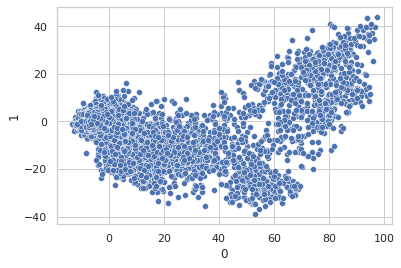

In [18]:
sns.scatterplot(x=pca_df[0],y=pca_df[1])

Hrmmmm... there might even be some clusters in that.

It seems to me that I should check the total range of the first several PCA columns and then shrink them to be proportional to the amount of variation those dimensions explain. I don't have any theoretical justification for this; it just sounds reasonable.

In [19]:
print(pca_df.loc[:,0:6].min(),'\n',pca_df.loc[:,0:6].max())

0   -13.264071
1   -39.080326
2   -27.349713
3   -36.893205
4   -24.195581
5   -24.178498
6   -35.158631
dtype: float64 
 0    97.329572
1    43.987695
2    41.765544
3    42.829925
4    31.531683
5    32.382433
6    45.266259
dtype: float64


In [20]:
ranges = pca_df.loc[:,0:6].max()-pca_df.loc[:,0:6].min()
ranges

0    110.593643
1     83.068021
2     69.115257
3     79.723130
4     55.727264
5     56.560931
6     80.424890
dtype: float64

They definitely do not taper evenly.

In [21]:
variances = pca.explained_variance_ratio_
top_var = variances[0]
scaled_variances = variances * 100 / top_var
scaled_variances[0:6]

array([100.        ,  13.92530325,  11.18938767,  10.12546597,
         7.3839208 ,   7.22165958])

In [22]:
print(pca_df.loc[:,0:6].min(),'\n',pca_df.loc[:,0:6].max())
pca_df.loc[:,0:6].max()-pca_df.loc[:,0:6].min()

0   -13.264071
1   -39.080326
2   -27.349713
3   -36.893205
4   -24.195581
5   -24.178498
6   -35.158631
dtype: float64 
 0    97.329572
1    43.987695
2    41.765544
3    42.829925
4    31.531683
5    32.382433
6    45.266259
dtype: float64


0    110.593643
1     83.068021
2     69.115257
3     79.723130
4     55.727264
5     56.560931
6     80.424890
dtype: float64

In [23]:
scaled_pca6 = pca_df.loc[:,0:6].copy()
for col in range(6):
    scaled_pca6.loc[:,col] = scaled_pca6.loc[:,col] * scaled_variances[col] / ranges[col]
print(scaled_pca6.loc[:,0:6].min(),'\n',scaled_pca6.loc[:,0:6].max())
scaled_pca6.loc[:,0:6].max()-scaled_pca6.loc[:,0:6].min()

0   -11.993520
1    -6.551323
2    -4.427771
3    -4.685728
4    -3.205940
5    -3.087094
6   -35.158631
dtype: float64 
 0    88.006480
1     7.373981
2     6.761616
3     5.439738
4     4.177981
5     4.134566
6    45.266259
dtype: float64


0    100.000000
1     13.925303
2     11.189388
3     10.125466
4      7.383921
5      7.221660
6     80.424890
dtype: float64

3. Conduct elbow and/or silhouette tests of the data reduced to various PCA dimensions. (I semi-intentionally picked a maximum of 6.)

This calls for a gridsearch loop:
* Loop over dimensions 1 to 6
    * Loop over k = 1 to 10
        * KMeans
        * save scores and silhouette_scores
    * plot scores and silhouette_scores
    * DBSCAN, defaults
        * save score and silhouette_score
    * MeanShift, defaults
        * save score and silhouette_score
* Plot DBSCAN and MeanShift results

In [24]:
del scaled_pca6[6]
scaled_pca6.head()

,0,1,2,3,4,5
sig_id,,,,,,
id_000644bb2,-6.426463,-0.195931,-0.050287,0.979029,-0.557404,-0.367234
id_000779bfc,-5.752181,0.622689,1.162110,-0.556346,0.492277,0.421725
id_000a6266a,-1.565927,0.400469,-0.520239,-0.660153,0.051907,-0.128458
id_0015fd391,8.304105,-0.461672,-0.824670,-1.093577,-0.658432,-0.810423
id_001626bd3,-5.852212,0.170955,0.670244,-1.079069,-0.402676,-0.295247


In [29]:
def plot_sil_scores(pca_input):
    k_sils = []
    d_sils = []
    m_sils = []
    for dim in range(1,6):
        k_sils.append([])
        data = pca_input.loc[:,0:dim-1].copy()
        for k in range(2,11):
            model = KMeans(n_clusters=k)
            model.fit(data)
            labels = model.labels_
            k_sils[dim-1].append(metrics.silhouette_score(data,labels))
        k_df = pd.DataFrame(k_sils,index=[f'd{i+1}' for i in range(len(k_sils))],
            columns=[f'k={k+2}' for k in range(len(k_sils[0]))]).T
        plt.title(f'KMeans in {dim} PCA dimensions')
        for col in list(k_df.columns):
            sns.scatterplot(x=range(2,11),y=k_df[col])
        plt.legend()
        plt.show()
        db = DBSCAN()
        db.fit(data)
        labels = db.labels_
        d_sils.append(metrics.silhouette_score(data,labels))
        ms = MeanShift()
        ms.fit(data)
        labels = ms.labels_
        m_sils.append(metrics.silhouette_score(data,labels))
    plt.title('DBSCAN results for varying PCA dimensions')
    sns.scatterplot(x=range(1,6),y=d_sils)
    plt.legend()
    plt.show()
    plt.title('Mean Shift results for varying PCA dimensions')
    sns.scatterplot(x=range(1,6),y=m_sils)
    plt.legend()
    plt.show()
    return k_sils, d_sils, m_sils

No handles with labels found to put in legend.


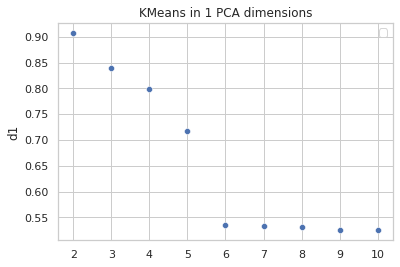

No handles with labels found to put in legend.


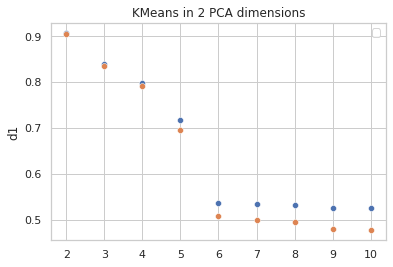

No handles with labels found to put in legend.


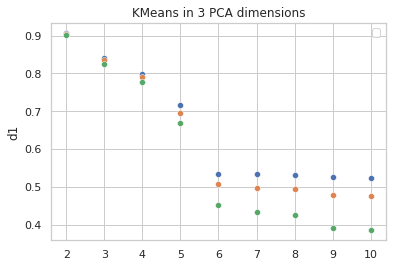

No handles with labels found to put in legend.


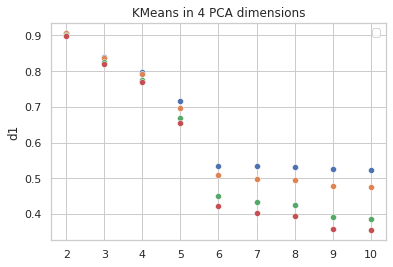

No handles with labels found to put in legend.


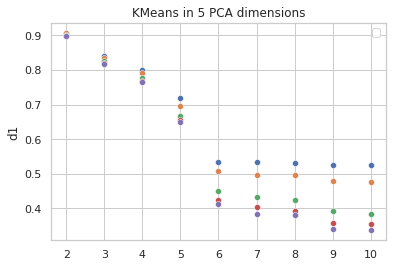

No handles with labels found to put in legend.


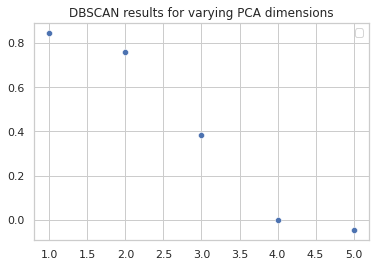

No handles with labels found to put in legend.


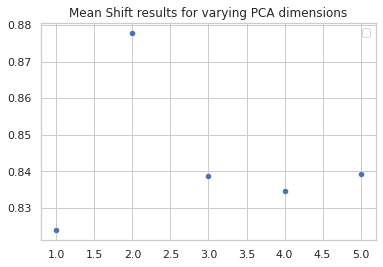

In [30]:
k_sils, d_sils, m_sils = plot_sil_scores(scaled_pca6)

In [31]:
k_df = pd.DataFrame(k_sils,index=[f'd{i+1}' for i in range(len(k_sils))],
                    columns=[f'k={k+2}' for k in range(len(k_sils[0]))]).T
k_df

,d1,d2,d3,d4,d5
k=2,0.907701,0.905620,0.901629,0.899602,0.898656
k=3,0.840075,0.835749,0.824947,0.820743,0.818225
k=4,0.798806,0.792007,0.776689,0.768718,0.765935
k=5,0.717975,0.696095,0.668389,0.654706,0.650776
k=6,0.535339,0.508561,0.451603,0.423260,0.412728
k=7,0.533575,0.497871,0.433898,0.403568,0.384955
k=8,0.532047,0.495445,0.424944,0.393533,0.381073
k=9,0.525096,0.479661,0.392397,0.358474,0.341308
k=10,0.524647,0.476193,0.385195,0.354258,0.336414


Let me check what happens when I just pass the raw PCA to the clusterer.

No handles with labels found to put in legend.


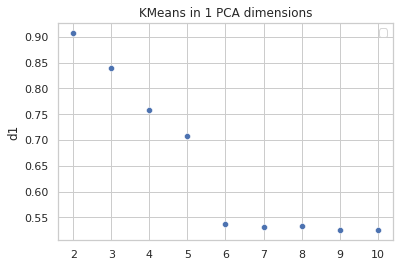

No handles with labels found to put in legend.


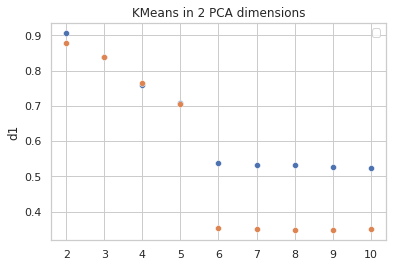

No handles with labels found to put in legend.


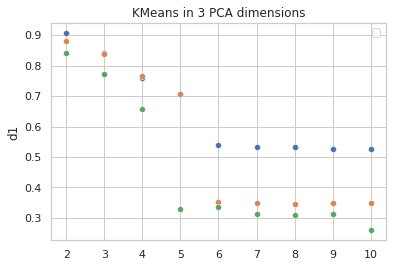

No handles with labels found to put in legend.


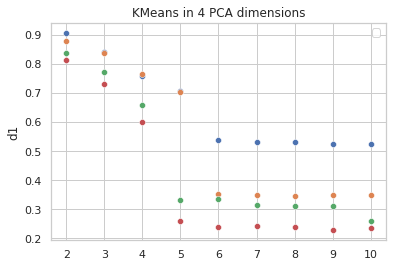

No handles with labels found to put in legend.


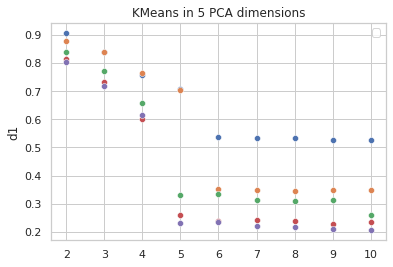

No handles with labels found to put in legend.


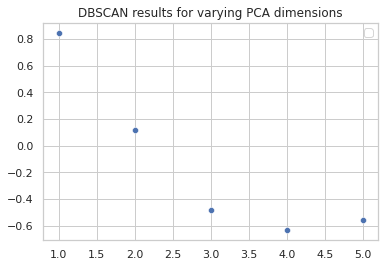

No handles with labels found to put in legend.


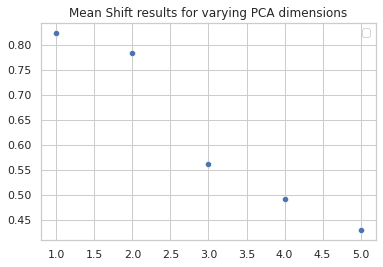

In [32]:
k2, d2, m2 = plot_sil_scores(pca_df)

In [ ]:
strategy = tf.distribute.get_strategy()
print("Number of accelerators: ", strategy.num_replicas_in_sync)

In [ ]:
with strategy.scope():
    inputs = Input(shape=(875,))
    x = Dense(1024,activation='elu')(inputs)
    x = Dropout(0.2,input_shape=(1024,))(x)
    x = Dense(256,activation='elu')(x)
    x = Dropout(0.2,input_shape=(256,))(x)
    x = Dense(64,activation='elu')(x)
    x = Dropout(0.2,input_shape=(64,))(x)
    outputs = Dense(206,activation='sigmoid')(x)
    model1 = Model(inputs,outputs)
    model1.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy"])

In [ ]:
model1.summary()

In [ ]:
n_epochs = 40
n_batch = 32
print('Starting Training')
model1.fit(tf_arr,tts_arr,epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

In [ ]:
tts_pred = model1.predict(tf_arr)
log_loss(tts_arr,tts_pred)

Wow, that's worse than my single layer model.
Now let's tune.

In [ ]:
!rm -R /kaggle/working/keras_tune

In [ ]:
def build_model(hp):
    inputs = Input(shape=(875,))
    x = Dense(
        units = hp.Choice('units 1',values=[64,256,1024]),
        activation = hp.Choice('activation function 1',values=['relu','elu'])
    )(inputs)
    x = Dropout(hp.Choice('dropout 1',values=[0.2,0.35,0.5]))(x)
    x = Dense(
        units = hp.Choice('units 2',values=[32,128,512]),
        activation = hp.Choice('activation function 2',values=['relu','elu'])
    )(x)
    x = Dropout(hp.Choice('dropout 2',values=[0.2,0.35,0.5]))(x)
    x = Dense(
        units = hp.Choice('units 3',values=[16,64,256]),
        activation = hp.Choice('activation function 3',values=['relu','elu'])
    )(x)
    x = Dropout(hp.Choice('dropout 3',values=[0.2,0.35,0.5]))(x)

    outputs = Dense(206,activation = hp.Choice('classify function',values =
                                              ['sigmoid','softmax']))(x)
    model = Model(inputs, outputs)
    # should throw in a choice of optimizer here: adam, etc.
    opt = tf.keras.optimizers.Adam(
        learning_rate=hp.Choice('learn rate',values=[0.01,0.001,0.0001]),
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    )
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['binary_crossentropy'])
    return model

In [ ]:
# let's try this
with strategy.scope():
    tuner = kerastuner.tuners.Hyperband(
            build_model,
            objective='binary_crossentropy',
            max_epochs=18,
            executions_per_trial=2,
            directory='keras_tune'
    )

In [ ]:
print('Starting Tuning')
X_train, X_val, y_train, y_val = train_test_split(tf_arr,tts_arr,test_size=0.2,random_state=84)
tuner.search(X_train,y_train,validation_data=(X_val,y_val))
print('Finished Tuning')

Chollet put this reasonably comprehensible notebook up on Kaggle: https://www.kaggle.com/fchollet/keras-kerastuner-best-practices/ Let's try the next steps from there.

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

In [ ]:
model2 = build_model(best_hp)
history = model2.fit(tf_arr, tts_arr, validation_split=0.2, epochs=50)

In [ ]:
model2.summary()

In [ ]:
val_logloss_per_epoch = history.history['val_binary_crossentropy']
best_epoch = val_logloss_per_epoch.index(max(val_logloss_per_epoch)) + 1
best_epoch

In [ ]:
model2a = build_model(best_hp)
model2a.fit(tf_arr, tts_arr, epochs=best_epoch)

In [ ]:
model2a.evaluate(tf_arr,tts_arr)

In [ ]:
# need dill to pickle these models?
# with open('/kaggle/working/model_design2.pkl', 'wb') as cellar:
#    pickle.dump(model2a,cellar)
model2a.summary()

In [ ]:
testf_df = pd.read_csv('../input/lish-moa/test_features.csv',index_col='sig_id')

In [ ]:
testf_df['cp_type']=testf_df['cp_type'].astype('category')
testf_df['cp_time']=scaler.transform((np.array(testf_df['cp_time'])).reshape(-1,1))
testf_df['cp_dose']=testf_df['cp_dose'].astype('category')
testf_df.loc[:,'g-0':'c-99']=transformer.transform(testf_df.loc[:,'g-0':'c-99'])
testf_df = oenc.transform(testf_df)
testf_df['cp_type']=testf_df['cp_type']-1
testf_df['cp_dose']=testf_df['cp_dose']-1
testf_arr = np.array(testf_df)

In [ ]:
tts_pred2 = model2a.predict(testf_arr)
sub_df = pd.DataFrame(tts_pred2,index=testf_df.index,columns=tts_df.columns)
sub_df.head()

In [ ]:
sub_df.to_csv('/kaggle/working/submission.csv')